# NLP with Disaster Tweet using RNN


### Github Repository for Notebook

https://github.com/jagrat89/DisasterTweet

### Problem Statement

This dataset contains tweets which have to be classified as disastorous or not. I will design an RNN to acheive this task. Further information can be found on the Kaggle page [Here](https://www.kaggle.com/competitions/nlp-getting-started/overview) 



In [162]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
from tensorflow.keras import regularizers
from gensim.models import Word2Vec

## EDA and Data Visualization

### Reading the Data

In [37]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Training Data

In [38]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Disastorous are labled as 1 and non-disastorous as 0, in the target coloumn

In [40]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [34]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


### Test Data

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### What is the distribution of tweets as disastorous and non-disastorous in the training data

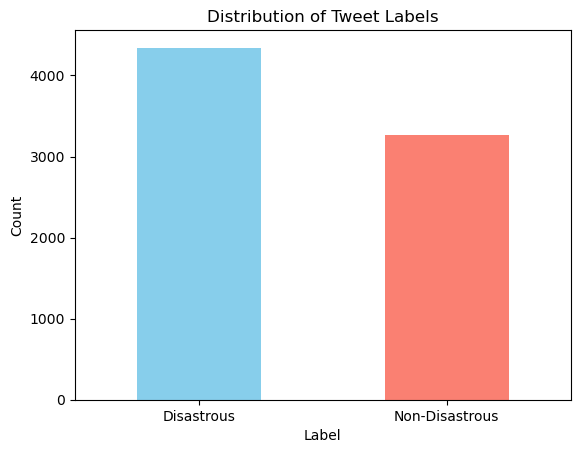

In [12]:
label_counts = train['target'].value_counts()
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Tweet Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1],['Disastrous', 'Non-Disastrous'], rotation=0) 
plt.show()

### How many NaNs do the Keyword and Location columns contain?

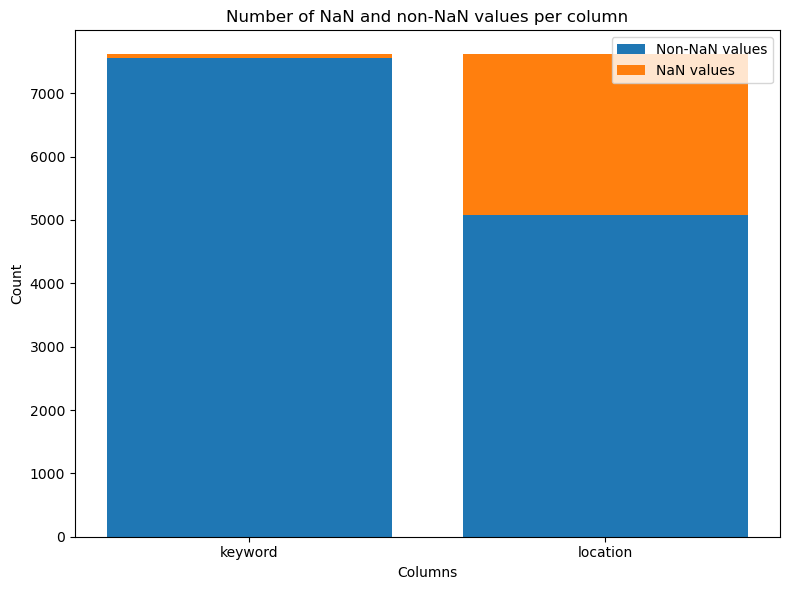

In [15]:
nan_counts = train[['keyword', 'location']].isnull().sum()

# Count non-NaN values
non_nan_counts = train[['keyword', 'location']].notnull().sum()

# Plotting
plt.figure(figsize=(8, 6))

plt.bar(nan_counts.index, non_nan_counts, color='#1f77b4', label='Non-NaN values')

plt.bar(nan_counts.index, nan_counts, bottom=non_nan_counts, color='#ff7f0e', label='NaN values')

plt.title('Number of NaN and non-NaN values per column')
plt.ylabel('Count')
plt.xlabel('Columns')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()


## Data Preprocessing

I will tokenize the tweets using the keras Tokenizer, this will convert the text from string to integers and build a vocabulary of the words

In [17]:
texts = train['text'].values

#### Creating and initializing the tokenizer

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
total_words = len(tokenizer.word_index) + 1

#### How many words are there in the vocabulary

In [19]:
total_words

22701

#### Converting the text to input sequence 

Text to sequences will convert the words in tweets to intgers which have been mapped over the vocabulary

In [20]:
input_sequences = tokenizer.texts_to_sequences(texts)

#### Padding the sequences for consistent length

In [21]:
input_sequences = pad_sequences(input_sequences, padding='post')

#### What is the shape of the input sequences

In [22]:
input_sequences.shape[1]

33

The longest Tweets in these dataset have 33 tokens

#### What does the integer sequence look like in contrast to string sequence

In [117]:
print(train["text"][1])
print(input_sequences[1])

Forest fire near La Ronge Sask. Canada
[ 189   45  229  799 6954 6955 1404    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


## Building a Model

## Vanilla RNN

The first model will be a vanilla RNN with 128 RNN cells and two stacked RNN Layers over each other, and a Dense sigmoid layer at the end for classification, the model will be trained with the adam optimizer.

In [44]:
model = Sequential()

model.add(Embedding(total_words, 64, input_length=input_sequences.shape[1]))

model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128))

# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 64)            1452864   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 33, 128)           24704     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1510593 (5.76 MB)
Trainable params: 1510593 (5.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model

In [46]:
target = train['target'].values 

history = model.fit(input_sequences, target, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
191/191 [==============================] - 3s 13ms/step - loss: 0.6265 - precision: 0.6559 - recall: 0.4344 - val_loss: 0.5723 - val_precision: 0.7026 - val_recall: 0.6530
Epoch 2/15
191/191 [==============================] - 2s 13ms/step - loss: 0.4134 - precision: 0.8489 - recall: 0.7256 - val_loss: 0.6964 - val_precision: 0.7325 - val_recall: 0.4711
Epoch 3/15
191/191 [==============================] - 2s 12ms/step - loss: 0.2188 - precision: 0.9290 - recall: 0.8837 - val_loss: 0.8374 - val_precision: 0.5924 - val_recall: 0.7010
Epoch 4/15
191/191 [==============================] - 2s 12ms/step - loss: 0.0987 - precision: 0.9656 - recall: 0.9543 - val_loss: 0.8988 - val_precision: 0.6823 - val_recall: 0.6361
Epoch 5/15
191/191 [==============================] - 2s 12ms/step - loss: 0.0555 - precision: 0.9781 - recall: 0.9766 - val_loss: 1.0755 - val_precision: 0.6627 - val_recall: 0.6347
Epoch 6/15
191/191 [==============================] - 2s 12ms/step - loss: 0.0490 - p

The model is overfitting the data and is performing very badly in validation as the val_loss keeps on increasing throughout training.

### Visualising the training

In [54]:
def plot_metrics(history):
    metrics = [metric for metric in history.history.keys() if not metric.startswith('val_')]
    num_metrics = len(metrics)
    
    # Set up the figure and axes
    fig, axes = plt.subplots((num_metrics + 2) // 3, 3, figsize=(15, num_metrics * 2))
    if num_metrics <= 3:
        axes = np.expand_dims(axes, 0) 
    
    for i, metric in enumerate(metrics):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        ax.plot(history.history[metric], label='Train ' + metric)
        ax.plot(history.history['val_' + metric], label='Validation ' + metric, linestyle='--')
        ax.set_title(metric)
        ax.legend()
        
    plt.tight_layout()
    plt.show()

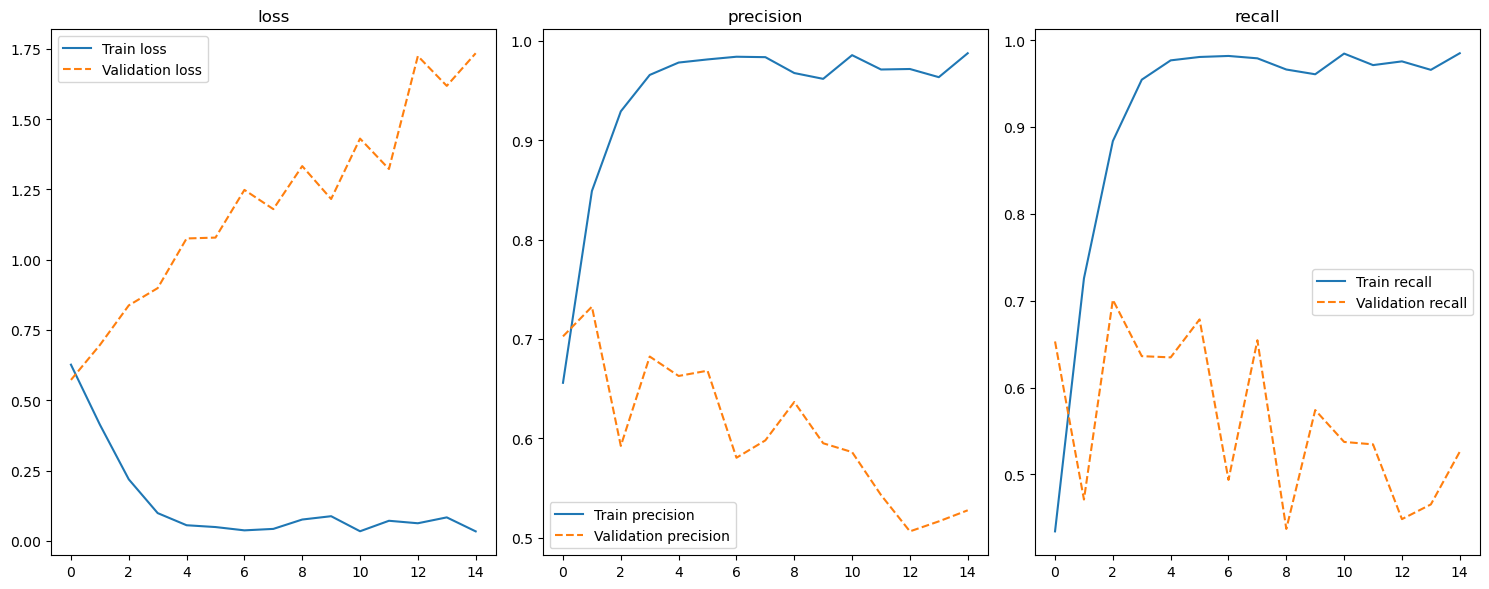

In [57]:
plot_metrics(history)

It is clear from the plots that the model is overfitting the data.

### Changing the model

Because the model is overfitting I will reduce the learning rate and add dropout layers in the model.

In [64]:
model = Sequential()

model.add(Embedding(total_words, 64, input_length=input_sequences.shape[1]))

model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(128))
model.add(Dropout(0.5))

# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.00001)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

### Training

I will train the model with additional epochs

In [65]:
history = model.fit(input_sequences, target, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 3s 13ms/step - loss: 0.7269 - precision: 0.4416 - recall: 0.4415 - val_loss: 0.6824 - val_precision: 0.5170 - val_recall: 0.3004
Epoch 2/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7071 - precision: 0.4573 - recall: 0.3868 - val_loss: 0.6776 - val_precision: 0.5263 - val_recall: 0.3244
Epoch 3/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6889 - precision: 0.4967 - recall: 0.4153 - val_loss: 0.6770 - val_precision: 0.5845 - val_recall: 0.2976
Epoch 4/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6722 - precision: 0.5194 - recall: 0.4083 - val_loss: 0.6683 - val_precision: 0.5910 - val_recall: 0.4076
Epoch 5/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6449 - precision: 0.5794 - recall: 0.4856 - val_loss: 0.6643 - val_precision: 0.6045 - val_recall: 0.4937
Epoch 6/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6105 - p

The model seems to perform better than the last one, but the val_loss starts to increase after converging to 0.65

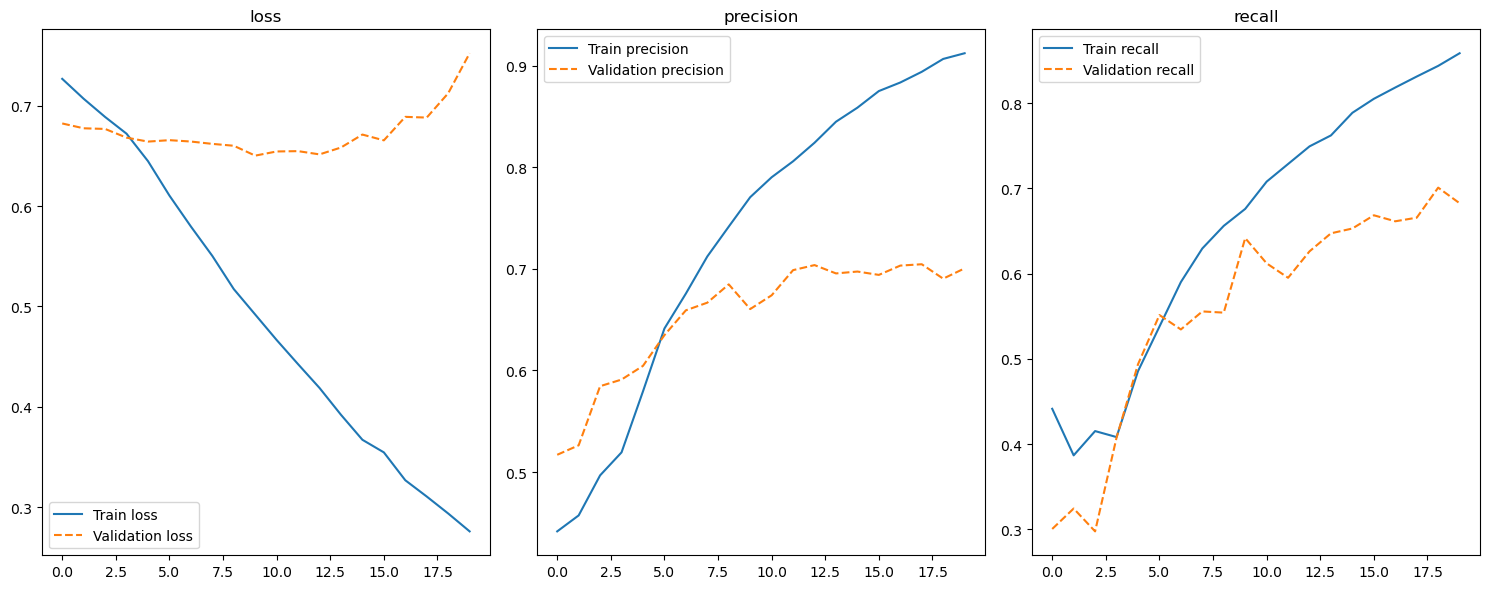

In [67]:
plot_metrics(history)

### Changing the Model

This time I will set the learning rate to 0.000006 and add regularizers with a regularization rate of 0.00001 

In [81]:
model = Sequential()

model.add(Embedding(total_words, 64, input_length=input_sequences.shape[1]))

model.add(SimpleRNN(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.00001), recurrent_regularizer=regularizers.l2(0.00001)))
model.add(Dropout(0.5))
model.add(SimpleRNN(128, kernel_regularizer=regularizers.l2(0.00001), recurrent_regularizer=regularizers.l2(0.00001)))
model.add(Dropout(0.5))
# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.000006)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

In [86]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 33, 64)            1452864   
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 33, 128)           24704     
                                                                 
 dropout_14 (Dropout)        (None, 33, 128)           0         
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1510593 (5.76 MB)
Trainable params: 151

In [82]:
history = model.fit(input_sequences, target, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 3s 13ms/step - loss: 0.7373 - precision: 0.4192 - recall: 0.3786 - val_loss: 0.7090 - val_precision: 0.4346 - val_recall: 0.1876
Epoch 2/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7246 - precision: 0.4362 - recall: 0.3587 - val_loss: 0.7057 - val_precision: 0.4302 - val_recall: 0.1608
Epoch 3/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7185 - precision: 0.4436 - recall: 0.3591 - val_loss: 0.7025 - val_precision: 0.4297 - val_recall: 0.1551
Epoch 4/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7150 - precision: 0.4409 - recall: 0.3349 - val_loss: 0.7008 - val_precision: 0.4260 - val_recall: 0.1340
Epoch 5/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7105 - precision: 0.4584 - recall: 0.3505 - val_loss: 0.6972 - val_precision: 0.4464 - val_recall: 0.1467
Epoch 6/20
191/191 [==============================] - 3s 13ms/step - loss: 0.7094 - p

This model is the best converging model till now it doesn't seem to overfit and is derceasing the training and validation rate

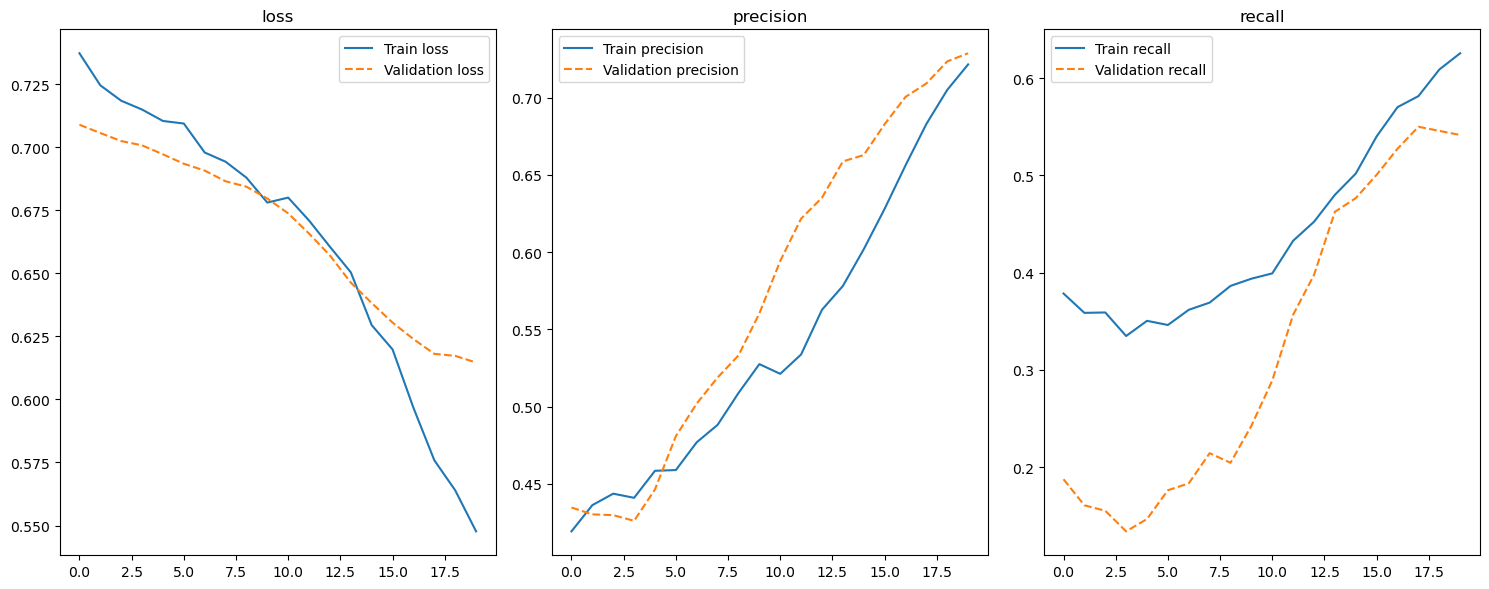

In [83]:
plot_metrics(history)

#### Training the model for additional epochs

In [84]:
history = model.fit(input_sequences, target, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
191/191 [==============================] - 2s 13ms/step - loss: 0.5254 - precision: 0.7357 - recall: 0.6347 - val_loss: 0.6129 - val_precision: 0.7350 - val_recall: 0.5515
Epoch 2/50
191/191 [==============================] - 3s 13ms/step - loss: 0.5122 - precision: 0.7564 - recall: 0.6495 - val_loss: 0.6046 - val_precision: 0.7298 - val_recall: 0.5980
Epoch 3/50
191/191 [==============================] - 2s 13ms/step - loss: 0.4946 - precision: 0.7639 - recall: 0.6780 - val_loss: 0.6044 - val_precision: 0.7407 - val_recall: 0.5882
Epoch 4/50
191/191 [==============================] - 3s 13ms/step - loss: 0.4882 - precision: 0.7722 - recall: 0.6827 - val_loss: 0.6001 - val_precision: 0.7435 - val_recall: 0.6093
Epoch 5/50
191/191 [==============================] - 3s 13ms/step - loss: 0.4634 - precision: 0.7973 - recall: 0.7034 - val_loss: 0.5960 - val_precision: 0.7430 - val_recall: 0.6361
Epoch 6/50
191/191 [==============================] - 2s 13ms/step - loss: 0.4533 - p

The result training the model additional epochs showed that the model starts to overfit after reaching 0.60 validation loss

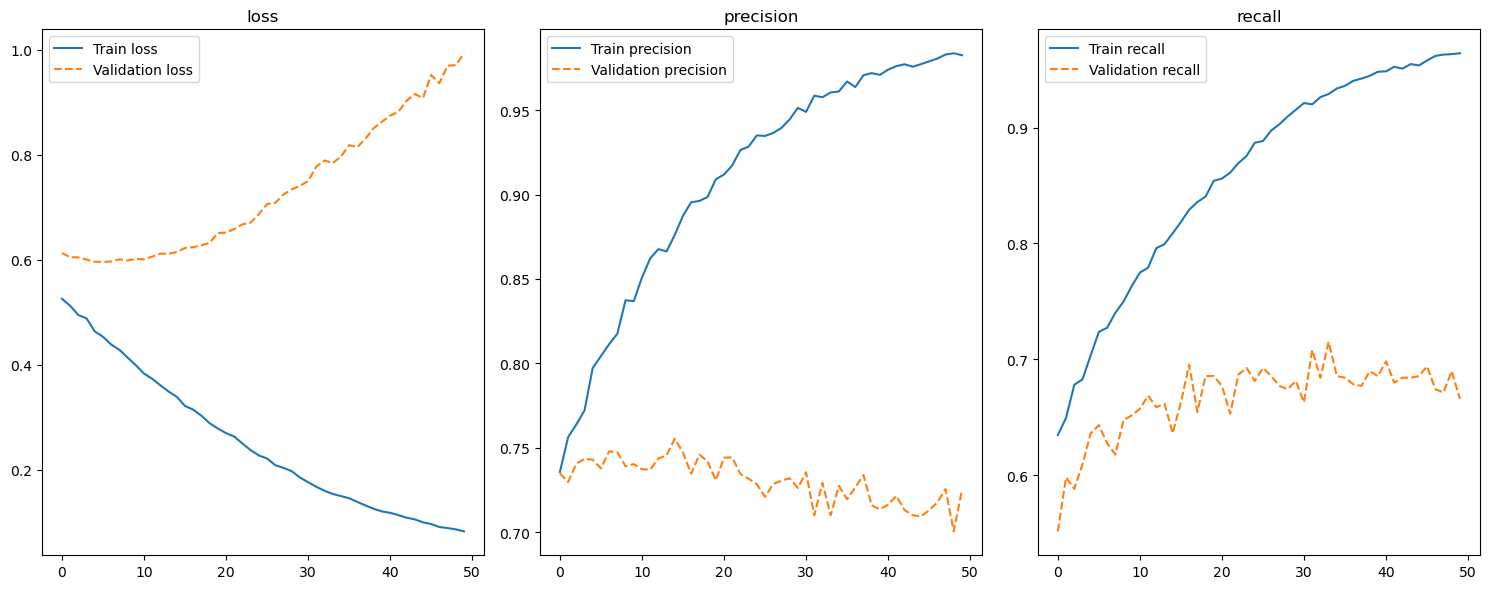

In [85]:
plot_metrics(history)

This plot shows that we have to change the hyperparameters for better performance

### Changing the Model

This time I will keep the learning rate 0.000006 and decrease the dropout rate to 0.2 to observe if it makes any difference

In [87]:
model = Sequential()

model.add(Embedding(total_words, 64, input_length=input_sequences.shape[1]))

model.add(SimpleRNN(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.00001), recurrent_regularizer=regularizers.l2(0.00001)))
model.add(Dropout(0.2))
model.add(SimpleRNN(128, kernel_regularizer=regularizers.l2(0.00001), recurrent_regularizer=regularizers.l2(0.00001)))
model.add(Dropout(0.2))
# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.000006)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

In [88]:
history = model.fit(input_sequences, target, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 3s 13ms/step - loss: 0.7101 - precision: 0.4292 - recall: 0.3774 - val_loss: 0.6967 - val_precision: 0.5339 - val_recall: 0.1890
Epoch 2/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6829 - precision: 0.5041 - recall: 0.2662 - val_loss: 0.6865 - val_precision: 0.5681 - val_recall: 0.2059
Epoch 3/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6758 - precision: 0.5183 - recall: 0.2986 - val_loss: 0.6776 - val_precision: 0.5993 - val_recall: 0.2426
Epoch 4/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6616 - precision: 0.5705 - recall: 0.3427 - val_loss: 0.6667 - val_precision: 0.6467 - val_recall: 0.3202
Epoch 5/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6471 - precision: 0.5973 - recall: 0.4012 - val_loss: 0.6508 - val_precision: 0.6474 - val_recall: 0.4274
Epoch 6/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6288 - p

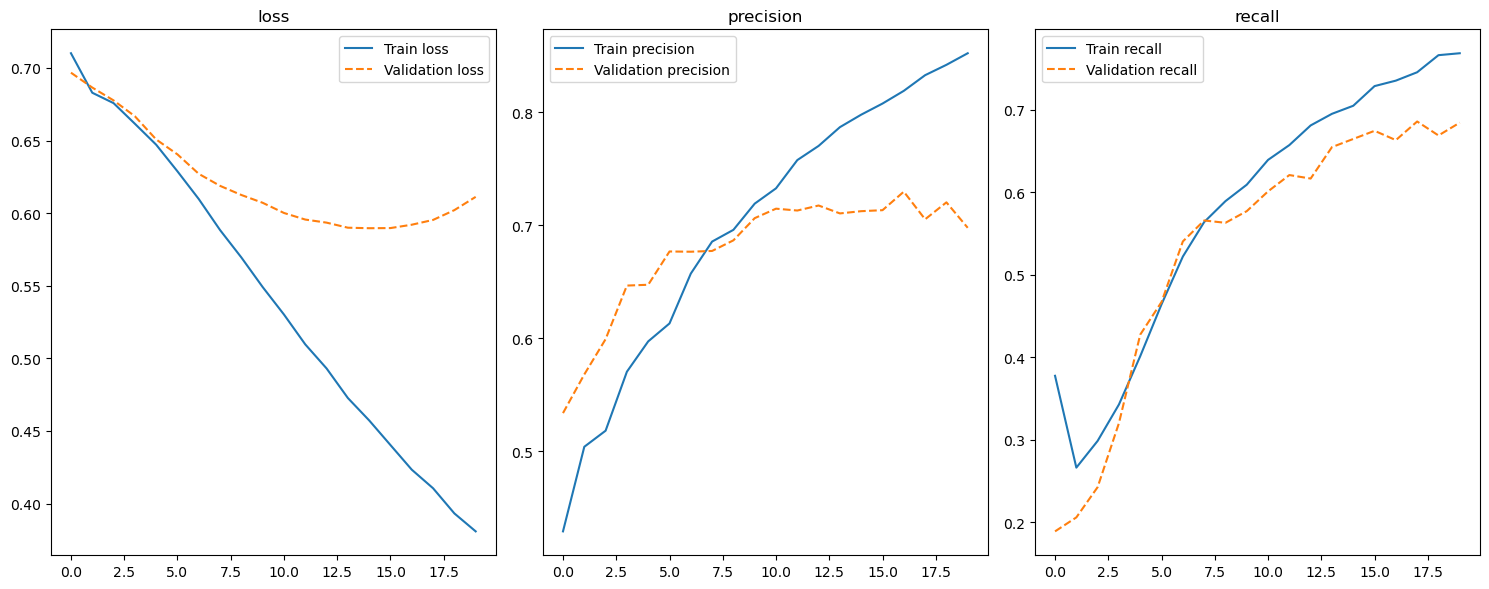

In [89]:
plot_metrics(history)

Decresing the dropout rate shows increase in val_loss compared to a dropout rate of 0.5, the val loss starts increasing after the 10th epoch

### Changing the Model 

I will decrease the regularization rate to 0.000001 to see if it performs better in validation set

In [92]:
model = Sequential()

model.add(Embedding(total_words, 64, input_length=input_sequences.shape[1]))

model.add(SimpleRNN(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.000001), recurrent_regularizer=regularizers.l2(0.000001)))
model.add(Dropout(0.7))
model.add(SimpleRNN(128, kernel_regularizer=regularizers.l2(0.000001), recurrent_regularizer=regularizers.l2(0.000001)))
model.add(Dropout(0.7))
# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.000006)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

In [93]:
history = model.fit(input_sequences, target, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 3s 13ms/step - loss: 0.7984 - precision: 0.4205 - recall: 0.5449 - val_loss: 0.6967 - val_precision: 0.4906 - val_recall: 0.3695
Epoch 2/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7782 - precision: 0.4276 - recall: 0.4602 - val_loss: 0.6905 - val_precision: 0.5568 - val_recall: 0.2144
Epoch 3/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7659 - precision: 0.4304 - recall: 0.4200 - val_loss: 0.6902 - val_precision: 0.5541 - val_recall: 0.1735
Epoch 4/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7418 - precision: 0.4463 - recall: 0.4169 - val_loss: 0.6901 - val_precision: 0.5612 - val_recall: 0.1551
Epoch 5/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7417 - precision: 0.4487 - recall: 0.4012 - val_loss: 0.6880 - val_precision: 0.5692 - val_recall: 0.1566
Epoch 6/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7397 - p

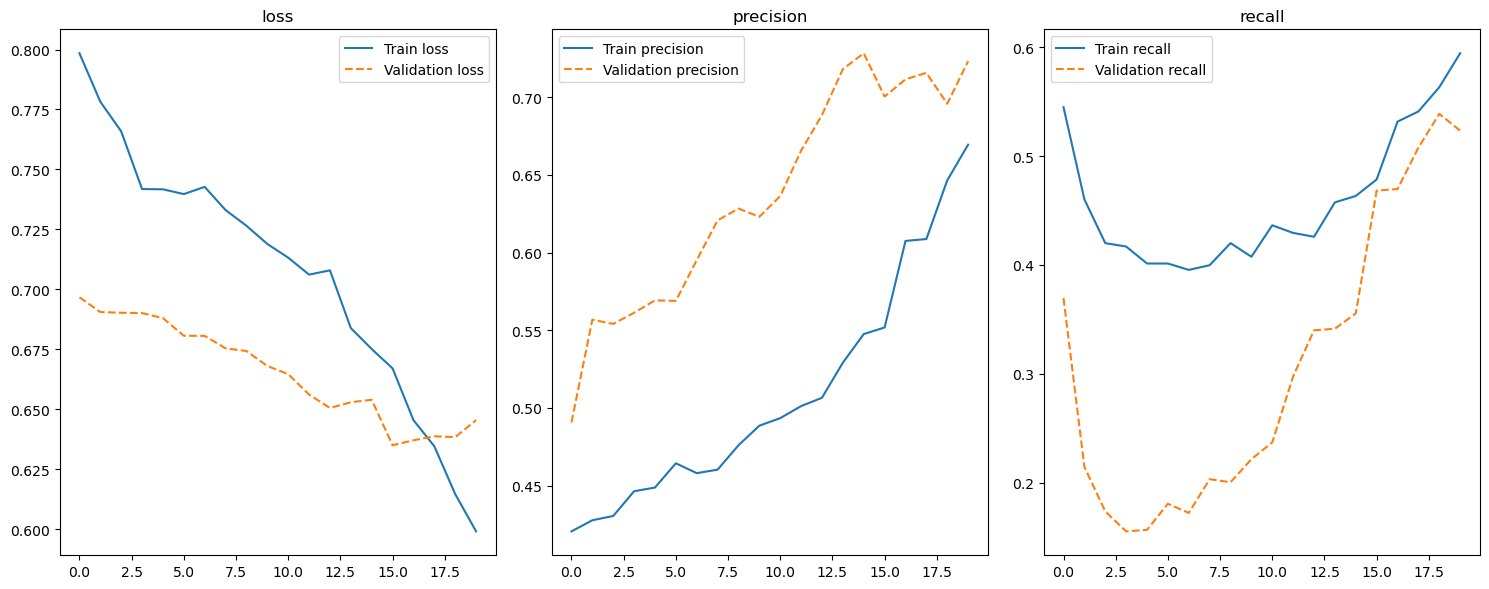

In [94]:
plot_metrics(history)

### Submission 

The best Vanilla RNN model in all these experiments thus far had the hyperparameters lr: 0.000006, dropout: 0.5 and regularization rate: 0.00001, with a val_loss of 0.60 and training loss of 0.48, I will be using this model for test submission.

### Building and Training the submission model

In [95]:
model = Sequential()

model.add(Embedding(total_words, 64, input_length=input_sequences.shape[1]))

model.add(SimpleRNN(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.00001), recurrent_regularizer=regularizers.l2(0.00001)))
model.add(Dropout(0.5))
model.add(SimpleRNN(128, kernel_regularizer=regularizers.l2(0.00001), recurrent_regularizer=regularizers.l2(0.00001)))
model.add(Dropout(0.5))
# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.000006)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

history = model.fit(input_sequences, target, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 4s 13ms/step - loss: 0.7339 - precision: 0.4363 - recall: 0.3849 - val_loss: 0.7037 - val_precision: 0.5015 - val_recall: 0.2426
Epoch 2/20
191/191 [==============================] - 2s 13ms/step - loss: 0.7262 - precision: 0.4342 - recall: 0.3310 - val_loss: 0.6945 - val_precision: 0.5267 - val_recall: 0.2228
Epoch 3/20
191/191 [==============================] - 3s 13ms/step - loss: 0.7095 - precision: 0.4621 - recall: 0.3400 - val_loss: 0.6870 - val_precision: 0.5483 - val_recall: 0.2482
Epoch 4/20
191/191 [==============================] - 3s 13ms/step - loss: 0.7037 - precision: 0.4664 - recall: 0.3489 - val_loss: 0.6806 - val_precision: 0.5659 - val_recall: 0.2906
Epoch 5/20
191/191 [==============================] - 2s 13ms/step - loss: 0.6941 - precision: 0.4965 - recall: 0.3923 - val_loss: 0.6763 - val_precision: 0.5863 - val_recall: 0.3018
Epoch 6/20
191/191 [==============================] - 3s 13ms/step - loss: 0.6905 - p

### Submission code

In [98]:
def predict_and_fill(csv_path, test_df, model, tokenizer, max_sequence_len):

    submission_df = pd.read_csv(csv_path)
    
    # Convert the text data for prediction
    test_sequences = tokenizer.texts_to_sequences(test_df['text'].values)
    test_padded = pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post')
    
    # Feed this text into the model for prediction
    predictions = model.predict(test_padded)
    
    # Convert predictions to binary values
    submission_df['target'] = (predictions > 0.5).astype(int)
    
    submission_df.to_csv('submission.csv', index=False)

In [100]:
predict_and_fill('sample_submission.csv', test, model, tokenizer, max_sequence_len=input_sequences.shape[1])

102/102 [==============================] - 0s 2ms/step


### Submission results

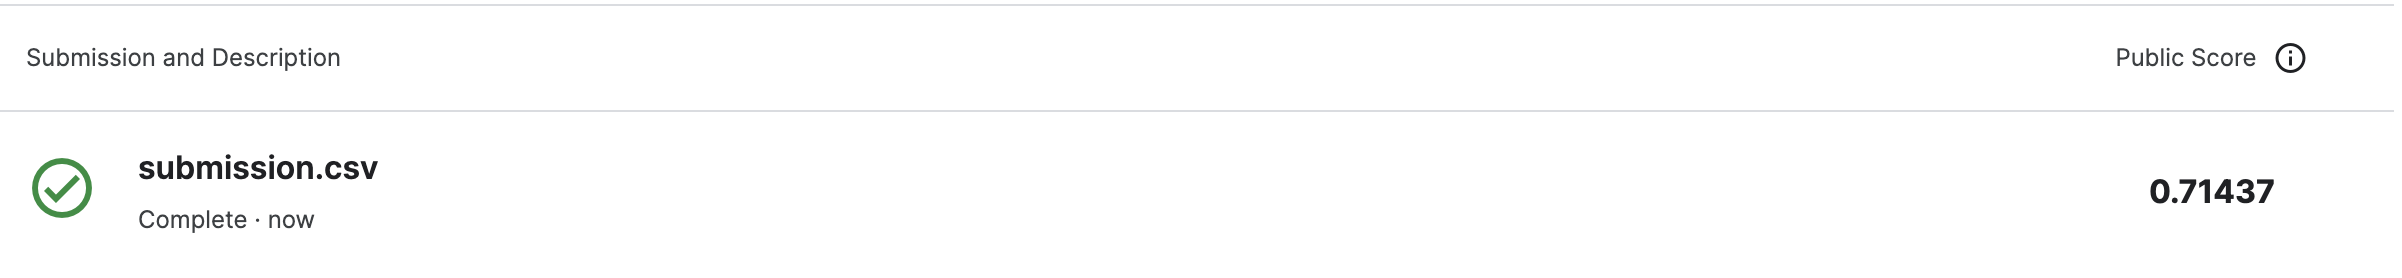

The submission results were similar to the val_precision and val_recall scores which were near 0.7

## Word2Vec Embedding

Word2Vec embedding rather than just mapping words to vectors, it creates embeddings for words which preserves it's relationship with other words. There are two ways in which the Word2Vec learns relationship between words that are **CBOW (Continuous Bag of Words)** and **Skip Gram**. 

In **CBOW** given a window size, a neural network needs to learn weights such that it can predict the center word from a window given the surrounding words.

In **Skip Gram** give a window size the neural network needs to learn weights such that it can predict the surrounding words of a window using the center word.

Once it has learnt the weights which capture the relationship between words, these weights are multiplied to the one hot encoded vectors of words which were used to train the neural network, this multiplication provides the appropriate embeddings for each word.

This a very short explanation of Word2Vec please refer to [this video](https://www.youtube.com/watch?v=UqRCEmrv1gQ) for detailed a explanation.

I will train a Word2Vec model for this dataset, using the gensim library. [This](https://www.kaggle.com/code/varun08/sentiment-analysis-using-word2vec) is good article for reference.


First we create sentences from tweets, the sentences will be fed to the Word2Vec model.

In [114]:
sentences = [text.split() for text in train['text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

#### What the model has learnt

The most_similar methods returns the similar words present in the model

In [127]:
word2vec_model.wv.most_similar("fire")

[('on', 0.9998013377189636),
 ('&amp;', 0.9997923970222473),
 ('from', 0.9997864365577698),
 ('with', 0.9997856616973877),
 ('in', 0.9997773766517639),
 ('2', 0.999771237373352),
 ('the', 0.9997591376304626),
 ('at', 0.999754786491394),
 ('for', 0.999746561050415),
 ('and', 0.9997397661209106)]

In [128]:
word2vec_model.wv.most_similar("collapse")

[('after', 0.9992504715919495),
 ('&amp;', 0.9992440938949585),
 ('The', 0.9992331266403198),
 ('in', 0.9992286562919617),
 ('into', 0.9992219805717468),
 ('by', 0.9992212653160095),
 ('at', 0.9992172122001648),
 ('a', 0.9992164969444275),
 ('the', 0.9992144107818604),
 ('over', 0.9992044568061829)]

In [130]:
word2vec_model.wv.most_similar("storm")

[('at', 0.999261200428009),
 ('&amp;', 0.9992193579673767),
 ('of', 0.9992131590843201),
 ('on', 0.9991899728775024),
 ('in', 0.9991840124130249),
 ('for', 0.9991594552993774),
 ('is', 0.9991481900215149),
 ('-', 0.999144971370697),
 ('out', 0.9991406798362732),
 ('with', 0.9991389513015747)]

Next step is to extract the embeddings from the word2vec model for using it in RNN embedding layer, for doing that we will extract the vectors per word corresponding to the tokenizer number of the words, tokenizer assigns a number to each unique word in the dataset

In [118]:
embedding_dim = word2vec_model.vector_size

embedding_matrix = np.zeros((total_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

Let's see what the embedding matrix looks like

In [126]:
embedding_matrix.shape

(22701, 100)

## Building the Model

I will use the same Vanilla RNN model as before to check if using word2vec makes any difference.

In [139]:
model = Sequential()

model.add(Embedding(total_words, 
                    embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=input_sequences.shape[1], 
                    trainable=False))

model.add(SimpleRNN(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.00001), recurrent_regularizer=regularizers.l2(0.00001)))
model.add(Dropout(0.5))
model.add(SimpleRNN(128, kernel_regularizer=regularizers.l2(0.00001), recurrent_regularizer=regularizers.l2(0.00001)))
model.add(Dropout(0.5))
# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.000006)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

history = model.fit(input_sequences, target, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 3s 11ms/step - loss: 0.7561 - precision: 0.4179 - recall: 0.4063 - val_loss: 0.7102 - val_precision: 0.4513 - val_recall: 0.2285
Epoch 2/20
191/191 [==============================] - 2s 10ms/step - loss: 0.7433 - precision: 0.4342 - recall: 0.3681 - val_loss: 0.7057 - val_precision: 0.4630 - val_recall: 0.1058
Epoch 3/20
191/191 [==============================] - 2s 10ms/step - loss: 0.7397 - precision: 0.4414 - recall: 0.3599 - val_loss: 0.7030 - val_precision: 0.5000 - val_recall: 0.0663
Epoch 4/20
191/191 [==============================] - 2s 10ms/step - loss: 0.7299 - precision: 0.4309 - recall: 0.3251 - val_loss: 0.6972 - val_precision: 0.5921 - val_recall: 0.1269
Epoch 5/20
191/191 [==============================] - 2s 10ms/step - loss: 0.7325 - precision: 0.4414 - recall: 0.3470 - val_loss: 0.6954 - val_precision: 0.6407 - val_recall: 0.1509
Epoch 6/20
191/191 [==============================] - 2s 10ms/step - loss: 0.7341 - p

In [142]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 33, 100)           2270100   
                                                                 
 simple_rnn_55 (SimpleRNN)   (None, 33, 128)           29312     
                                                                 
 dropout_43 (Dropout)        (None, 33, 128)           0         
                                                                 
 simple_rnn_56 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_44 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2332437 (8.90 MB)
Trainable params: 623

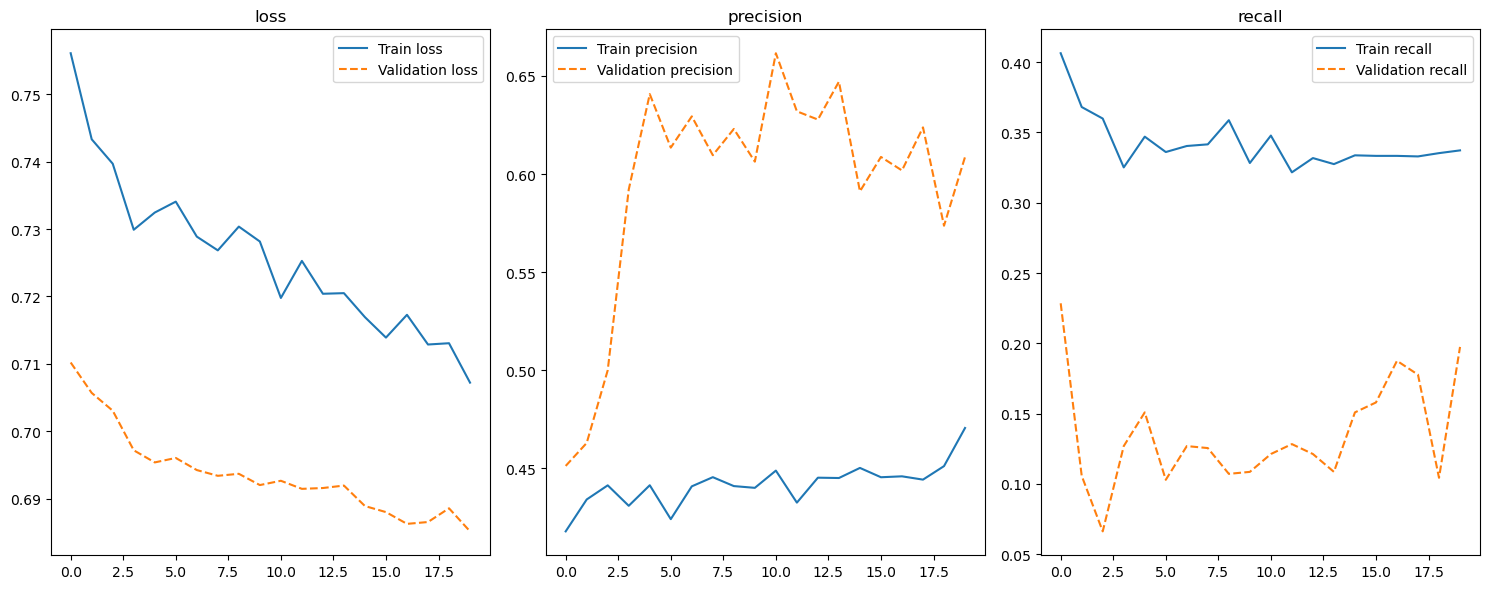

In [140]:
plot_metrics(history)

The model with word2vec is showing high overfitting compared to using a custom embedding layer which is trainable, lets try other architectures such as LSTM and GRU and observe the output.

## LSTM RNN

For this model I will use the Adam optimizer and four stacked LSTM layers with dropout rate of 0.5

In [ ]:
model = Sequential()

model.add(Embedding(total_words, 
                    embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=input_sequences.shape[1], 
                    trainable=False))

model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

history = model.fit(input_sequences, target, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 15s 70ms/step - loss: 0.6837 - precision: 0.3208 - recall: 0.0066 - val_loss: 0.6929 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 13s 68ms/step - loss: 0.6798 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6891 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
191/191 [==============================] - 13s 68ms/step - loss: 0.6771 - precision: 0.5052 - recall: 0.0379 - val_loss: 0.6835 - val_precision: 0.6000 - val_recall: 0.0085
Epoch 4/20
191/191 [==============================] - 13s 68ms/step - loss: 0.6724 - precision: 0.5227 - recall: 0.1167 - val_loss: 0.7016 - val_precision: 0.5500 - val_recall: 0.0155
Epoch 5/20
191/191 [==============================] - 13s 69ms/step - loss: 0.6674 - precision: 0.5296 - recall: 0.2201 - val_loss: 0.6723 - val_precision: 0.6108 - val_recall: 0.1749
Epoch 6/20
191/191 [==============================] - 13

### Submission

In [168]:
predict_and_fill('sample_submission.csv', test, model, tokenizer, max_sequence_len=input_sequences.shape[1])

102/102 [==============================] - 2s 14ms/step


### Submission Result

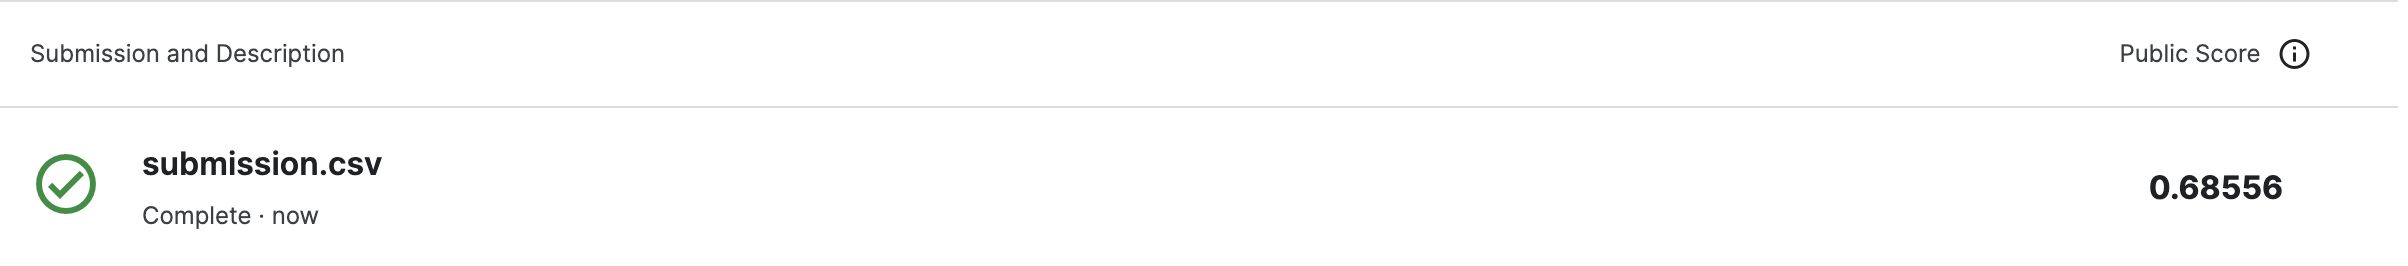

The result is similar to the the val_precision score of the model

# GRU RNN

The GRU RNN will have a four layers of RNN stacked over each other, with 128 GRU cell in each layer. 

In [176]:
model = Sequential()

model.add(Embedding(total_words, 
                    embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=input_sequences.shape[1], 
                    trainable=False))

model.add(GRU(128, return_sequences = True))
model.add(GRU(128, return_sequences = True))
model.add(GRU(128, return_sequences = True))
model.add(GRU(128))
# Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')])

In [177]:
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 33, 100)           2270100   
                                                                 
 gru_16 (GRU)                (None, 33, 128)           88320     
                                                                 
 gru_17 (GRU)                (None, 33, 128)           99072     
                                                                 
 gru_18 (GRU)                (None, 33, 128)           99072     
                                                                 
 gru_19 (GRU)                (None, 128)               99072     
                                                                 
 dense_46 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2655765 (10.13 MB)
Trainable params: 38

In [178]:
history = model.fit(input_sequences, target, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 13s 60ms/step - loss: 0.6811 - precision: 0.2143 - recall: 0.0012 - val_loss: 0.6913 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 11s 60ms/step - loss: 0.6791 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6928 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
191/191 [==============================] - 11s 60ms/step - loss: 0.6789 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6903 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
191/191 [==============================] - 11s 60ms/step - loss: 0.6787 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
191/191 [==============================] - 11s 60ms/step - loss: 0.6787 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6944 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/

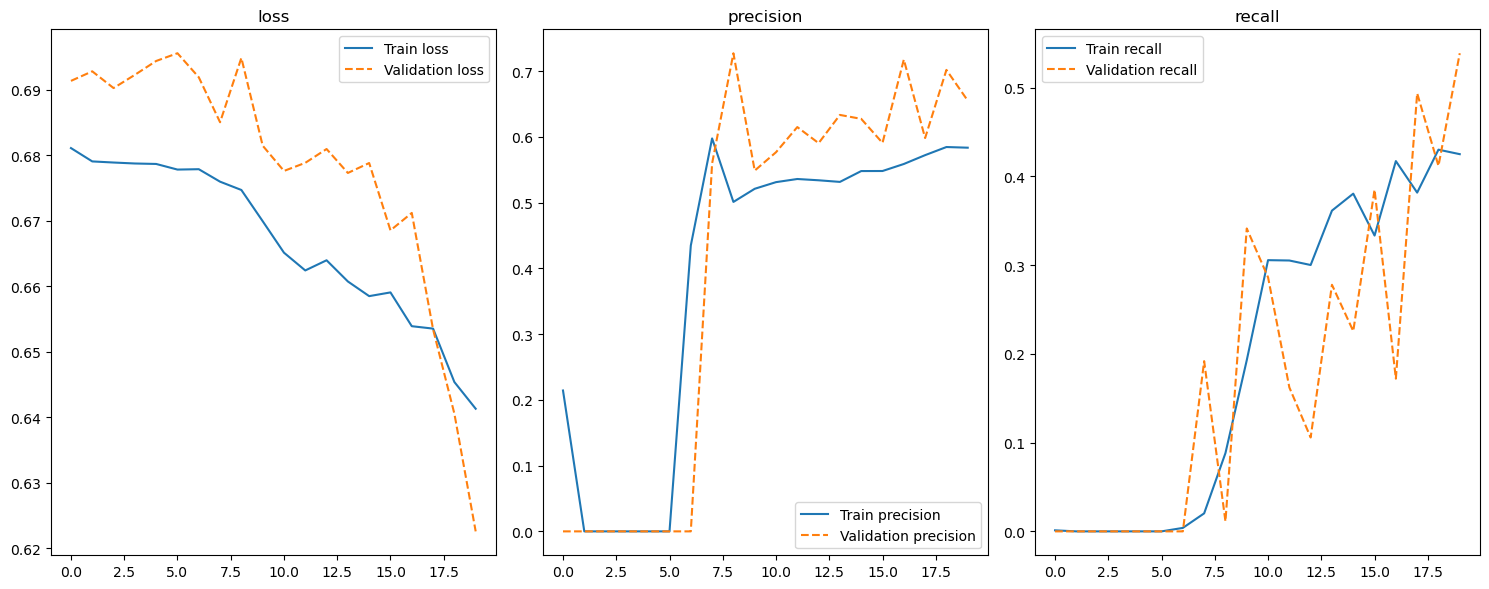

In [181]:
plot_metrics(history)

### Submission

In [180]:
predict_and_fill('sample_submission.csv', test, model, tokenizer, max_sequence_len=input_sequences.shape[1])


102/102 [==============================] - 1s 14ms/step


### Submission Result

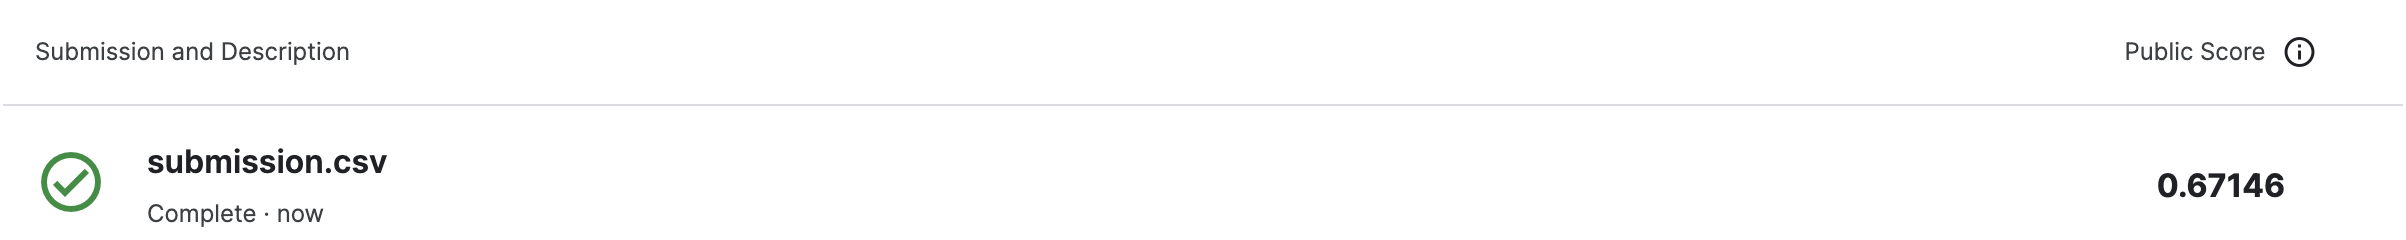

A test score of ~0.68

# Conclusion

In this notebook I have demonstrated several different models with different hyper-parameters and configurations. First I started with a Vanilla RNN and experimented with different hyper-parameters, then I used the word2vec embedding with the Vanilla RNN. I also demostrated LSTM RNN and GRU RNN both of which use word2vec embedding. Following is a table of test submission scores of each model from this notebook:

| Model | Test Score |
|-------|----------|
| Vanilla | 0.71 |
| LSTM | 0.68 |
| GRU  | 0.67 |

Further different models such as Bi-directional RNNs can be used to see if they perform better than other models. In order to make the current model better experiments with different optimizers and their learning_rates, experimenting with dropouts rates, regularization rates and different number of layers in the RNN architecture with more dense nodes before the ouput layer, can be experimented with to make a better model.